# MACD (Moving Average Convergence Divergence) Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### MACD process
* Long EMA (26 days)
* Short EMA (12 days)
* Signal EMA (9 days)
* MACD = Short EMA - Long EMA

* If MACD > Signal buy, else sell.
* A period hyper-parameter can be optimized for a given situation.

In [45]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [46]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [7]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [8]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [39]:
def MACD(pr_df, long_d=26, short_d=12, signal_d=9, min_days=1):
    pr = pr_df.copy()
    shortEMA = EMA(pr, short_d, min_days=min_days)
    longEMA = EMA(pr, long_d, min_days=min_days)
    pr['MACD'] = shortEMA - longEMA
    pr['Signal'] = EMA(pr[['MACD']], signal_d)
    return pr

In [36]:
def MACD_Signal(dff):
    df = dff.copy()
    df.columns = ['close','MACD','Signal']
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['MACD'][i] > df['Signal'][i] and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['MACD'][i] < df['Signal'][i] and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    return df

In [43]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [59]:
def MACD_Run(start, end, code, long_d=26, short_d=12, signal_d=9, min_p=1, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    macd = MACD(pr, long_d=long_d, short_d=short_d, signal_d=signal_d, min_days=min_p)
    if doplot :
        plt.style.use('fivethirtyeight')
        macd[['MACD','Signal']].plot(figsize=(8,6))
        plt.title("MACD & Signal for {}".format(code))
    macd_sig = MACD_Signal(macd)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(macd_sig.index, macd_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(macd_sig.index, macd_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(macd_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('MACD on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(macd_sig)
    rst.index = [code]
    return rst

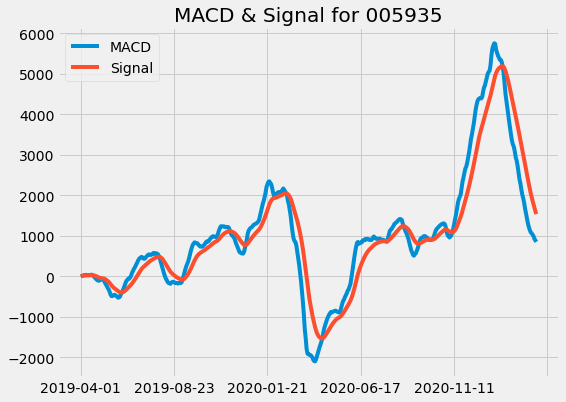

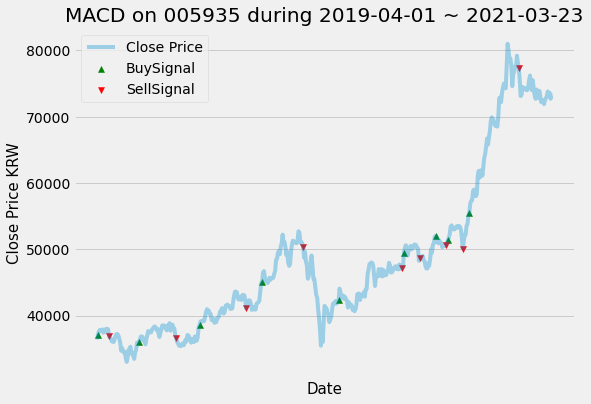

Wall time: 729 ms


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005935,1.76,0.56,0.39,-0.03,0.33,1.07,1.06,9,1.15


In [68]:
%%time
MACD_Run('2019-04-01','2021-03-23','005935',26,12,9,1,True)

In [72]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,MACD_Run(start, end, cd,26,12,9,1,False)])

Wall time: 653 ms


In [73]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.53,0.67,0.3,-0.04,0.32,1.05,1.05,9,0.93
005935,1.76,0.56,0.39,-0.03,0.33,1.07,1.06,9,1.15
034220,1.93,0.5,0.43,-0.05,0.6,1.13,1.12,6,1.31
066570,2.64,0.4,0.73,-0.05,0.23,1.14,1.1,10,1.33


# Conclusion
* It seems like better catching signal than OBV does.
* Tuning periods didn't improve performances large.
* Can be used with other indicators to check whether a signal is commonly generated or not.